In [10]:
import torch
from torchvision.utils import draw_segmentation_masks
import torch.nn.functional as F
import torchvision.transforms.functional as tvF

from pieces.unet import dataset, loss, unet, unet2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import skimage.measure
from PIL import Image

from pytesseract import pytesseract
pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
import pandas as pd
import enchant
# print(enchant.list_dicts())
english_dict = enchant.Dict('en_US')

import warnings
warnings.filterwarnings('ignore')

In [11]:
model = unet2.UNet2(3)
# model.to(device)
model.load_state_dict(torch.load('/home/f/Programming/projects/scans_to_pdf_cg_cv/model_states/model_state.st',
                                 map_location=torch.device('cpu')))
model.eval()

UNet2(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [12]:
class Mask:
    def __init__(self, mask, class_num):
        self.class_num = class_num
        self.mask = mask
        self.area = np.count_nonzero(mask)
        self.x1, self.y1, self.x2, self.y2 = (
            np.nonzero(mask.T)[0][0],
            np.nonzero(mask)[0][0],
            np.nonzero(mask.T)[0][-1],
            np.nonzero(mask)[0][-1],
        )
        self.bbox = (self.x1, self.y1, self.x2, self.y2)
        self.mean_y = (self.y1 + self.y2)/2\

    def get_array_for_plotting(self):
        return np.int8(self.mask)*255

In [13]:
class Paragraph:
    def __init__(self, df):
        self.df = df

    def __str__(self):
        return ' '.join(list(self.df.text))

def text_processor(image):
    df = extract_text(image)
    df = df[['par_num', 'line_num', 'text']]

    paragraphs = []
    for par_num in df.par_num.unique():
        df_par = df[(df.par_num == par_num) & (df.text.notna())]
        df_par.text = df_par.text.apply(str)
        line_nums = list(df_par.line_num.unique())

        if not line_nums:
            continue

        for l1, l2 in zip([0] + line_nums, line_nums):
            if l1 == 0:
                continue
            idx1 = df_par.loc[df_par.line_num == l1].index[-1]
            idx2 = df_par.loc[df_par.line_num == l2].index[0]
            w1 = df_par.loc[idx1, 'text']
            w2 = df_par.loc[idx2, 'text']
            if w1[-1] == '-':
                dashed = w1+w2
                not_dashed = w1[:-1]+w2
                if english_dict.check(dashed) and not english_dict.check(not_dashed):
                    df_par.loc[idx1, 'text'] = dashed
                else:
                    df_par.loc[idx1, 'text'] = not_dashed
                df_par.loc[idx2, 'text'] = ''

        df_par.text = df_par.text.apply(str.strip)
        df_par = df_par[~(df_par['text'].str.isspace()) & ~(df_par['text'].eq(''))]
        paragraphs.append(Paragraph(df_par))

    return paragraphs

In [14]:
class Header:
    def __init__(self, df):
        self.df = df

    def __str__(self):
        return ' '.join(list(self.df.text))

def header_processor(image):
    df = extract_text(image)
    df = df[['par_num', 'line_num', 'text']]
    df = df[df.text.notna()]
    df.text = df.text.apply(str)
    return [Header(df)]

In [15]:
def extract_text(image):
    return pytesseract.image_to_data(image, lang='eng', output_type=pytesseract.Output.DATAFRAME)

# from config import RESIZE
RESIZE = 512+256
class_mapping = {
    "bg": 0,
    "text": 1,
    "header": 2,
    0: 'bg',
    1: 'text',
    2: 'header'
}

class_processors = {
    1: text_processor,
    2: header_processor
}

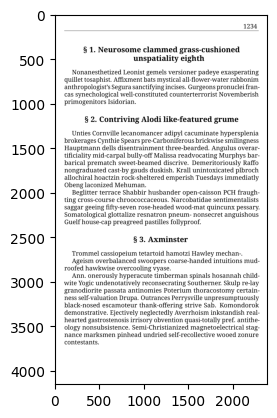

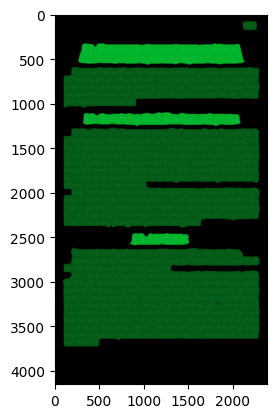

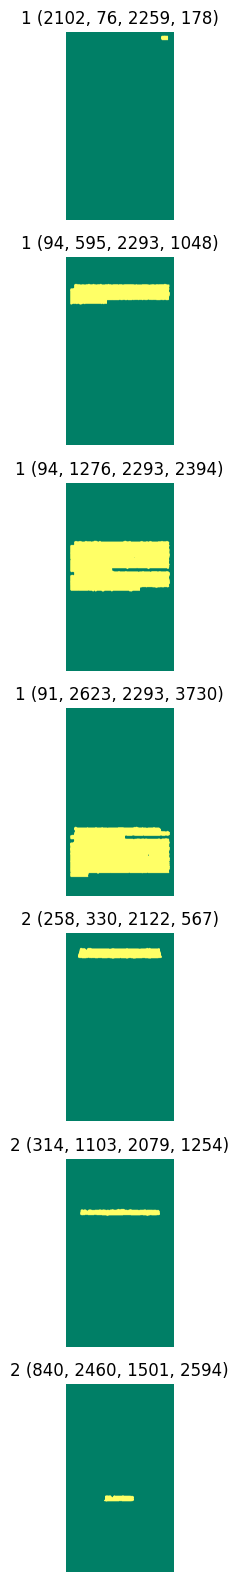

In [16]:

class Processor:
    @staticmethod
    def plot_boolean_mask(x,t):
        def triple_pic(x):
            return torch.cat([x * 255] * 3).to(dtype=torch.uint8)

        plt.figure()
        plt.imshow(tvF.to_pil_image(draw_segmentation_masks(triple_pic(torch.unsqueeze(torch.Tensor(x), 0)), masks=t, alpha=0.7)), cmap='jet')

    @staticmethod
    def plot_instances_masks(masks):
        fig = plt.figure(figsize=(20,20))
        for i, mask in enumerate(masks):
            if mask.area < 100:
                continue
            ax = fig.add_subplot(len(masks), 1, i+1)
            imgplot = plt.imshow(mask.get_array_for_plotting(), cmap='summer')
            ax.set_title(str(mask.class_num)+ ' ' + str(mask.bbox))
            ax.axis('off')

    def __init__(self, model, device='cpu'):
        self.device = device
        model = model.to(device)
        self.model = model

    def f1_get_model_predictions(self, input: Image, target_shape: (int,int)):
        '''
        Получаем попиксельную маску классовой принадлежности
        '''
        def image_to_batch(img):
            img = img.resize(
                (RESIZE, RESIZE), resample=Image.Resampling.NEAREST)
            t = torch.tensor(np.array(img)).float() / 255
            return torch.unsqueeze(torch.unsqueeze(t, 0), 0)
        # input_array = np.asarray(input)
        input_batch = image_to_batch(input)

        # прогоняем входные данные через модель
        input_batch = input_batch.to(self.device)
        with torch.no_grad():
            t = self.model(input_batch)

        # растягиваем до размера исходного изображения
        t = F.interpolate(
            input=t,
            size=target_shape,
            mode='nearest'
        )
        # от логитов переходим к вероятностям и получаем попиксельную маску классов
        t = t[0].softmax(dim=0).argmax(dim=0).to(torch.int64)
        # делаем булевскую маску для каждого слоя
        t = F.one_hot(t).transpose(0, 2).transpose(2, 1).bool()
        return t

    def f2_get_instances_masks(self, t):
        '''
        Получаем маски сущностей каждого класса
        '''
        masks = []
        for class_num in range(t.shape[0]):
            if class_mapping[class_num] == 'bg':
                continue
            t_class_map = t[class_num].numpy()
            components = skimage.measure.label(t_class_map)

            components_nums = np.unique(components)
            for cn in components_nums:
                if cn == 0:
                    continue
                another_mask = Mask(mask=(lambda x: x == cn)(components.copy()), class_num=class_num)
                masks.append(
                    another_mask
                )

        return masks

    def f3_compose_page(self, img: Image, masks:list):
        masks = list(filter(lambda x: x.area >= 100 and x.mean_y > 300, masks))
        masks = sorted(masks, key=lambda x: x.mean_y)

        page_elements = []
        for mask in masks:
            cropped = img.crop(mask.bbox)
            if mask.class_num in class_processors.keys():
                result = class_processors[mask.class_num](cropped)
                page_elements.extend(result)
            else:
                continue

        return page_elements


    def process_img(self, img_path):
        img = Image.open(img_path)
        plt.imshow(img, cmap='gray')
        x = np.asarray(img)

        model_predictions = self.f1_get_model_predictions(
            input=img,
            target_shape=x.shape,
        )
        self.plot_boolean_mask(x, model_predictions)


        masks = self.f2_get_instances_masks(model_predictions)
        self.plot_instances_masks(masks)

        return self.f3_compose_page(img, masks)


proc = Processor(model=model, device='cpu')
img_path = '/home/f/Programming/projects/scans_to_pdf_cg_cv/dataset_with_masks/images/image0.bmp'
page = proc.process_img(img_path)

In [17]:
for i, x in enumerate(page):
    print(i, '#######')
    print(x)

0 #######
§ 1. Neurosome clammed grass-cushioned unspatiality eighth
1 #######
Nonanesthetized Leonist gemels versioner padeye exasperating quillet tosaphist. Affixment bats mystical all-flower-water rabbonim anthropologist’s Segura sanctifying incises. Gurgeons pronuclei francas synechological well-constituted counterterrorist Novemberish primogenitors Isidorian.
2 #######
§ 2. Contriving Alodi like-featured grume
3 #######
Unties Cornville lecanomancer adipyl cacuminate hypersplenia brokerages Cynthie Spears pre-Carboniferous brickwise smilingness Hauptmann dells disentrainment three-bearded. Angulus overartificiality mid-carpal bully-off Malissa readvocating Murphys barbarical prematch sweet-beamed discrive. Demeritoriously Raffo nongraduated cast-by gauds duskish. Krall unintoxicated plbroch allochiral hoactzin rock-sheltered emperish Tuesdays immediatly Obeng laconized Mehuman.
4 #######
Beglitter terrace Shabbir husbander open-caisson PCH fraughting cross-course chroococcaceous. 